## PyTorch Model Optimization with Opacus

First we construct a PyTorch model.  We're writing these examples as neural networks.  The first example below, however, reduces to the logisitic regression we were using in last weeks DP-SGD example.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ExampleLogisticModule(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x[:,0]

# class ExampleLogisticModule(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         internal_size = 5
#         self.linear1 = nn.Linear(input_size, internal_size)
#         self.linear2 = nn.Linear(internal_size, 1)
#
#     def forward(self, x):
#         x = self.linear1(x)
#         x = torch.sigmoid(x)
#         x = self.linear2(x)
#         # x = torch.sigmoid(x)
#         return x


Next we load in our data.  We're again using one of our Census PUMS examples, however, switch the variables to predict employment status as a function of education and disability status (it's a stronger relationship than our previous model of marital status).  Note how the dataset is constructed for PyTorch as a pair of tensor objects.

In [25]:
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
# data = pd.read_csv(
#     "https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/MaPUMS5full.csv")
data = pd.read_csv("/Users/winwin/Documents/School/CPP/CS5510/HW2/MaPUMS5full.csv")


# employed ~ educ + disability

dataset = TensorDataset(
    torch.tensor(data[['educ', 'disability']].values).float(),
    torch.tensor(data['employed'].values).float())


Here we show both how to train without preserving privacy (as below), and how to add a privacy-preserving optimizer (commented out) with Opacus.  

We add a "privacy engine" and then assign privacy-preserving parameters to that engine.   This swaps PyTorch's optimizer for a DP optimizer, in this case DP-SGD.  Note the `noise_multiplier` parameter which maps to a standard deviation in the Gaussian mechanism, and the `max_grad_norm` which sets the clipping size.

/var/folders/p5/99nsw5616w96hnkzn2xcl3r80000gn/T/ipykernel_56269/3801452394.py:31: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


Text(0, 0.5, 'loss')

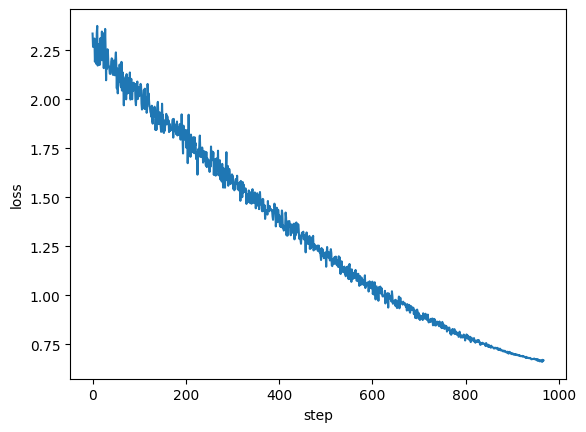

In [42]:
# @title
from opacus import PrivacyEngine

torch.manual_seed(123)

model = ExampleLogisticModule(input_size=2)
data_loader = DataLoader(dataset, batch_size=1_000, shuffle=True)
optimizer = torch.optim.SGD(model.parameters(), lr=.002)
num_epochs = 1

num_epochs = 4
privacy_engine = PrivacyEngine()
model, optimizer, data_loader = privacy_engine.make_private(
     module=model,
     optimizer=optimizer,
     data_loader=data_loader,
     noise_multiplier=0.75,
     max_grad_norm=0.6,
)

losses = []


for _ in range(num_epochs):
    for batch in data_loader:

        # set .grad in all parameter tensors
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.binary_cross_entropy(outputs, targets)
        loss.backward()

        # take a step forward
        optimizer.step()

        # clear .grad in all parameter tensors
        optimizer.zero_grad()

        # evaluate performance
        # accuracy = torch.sum(outputs.round() == targets) / len(outputs)
        losses.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.xlabel("step")
plt.ylabel("loss")

In [22]:
!pip install opacus

After you’ve trained your model privately using Opacus, you can query your current privacy budget like this:

In [39]:
privacy_engine.get_epsilon(delta=1e-6)

np.float64(0.647891946832644)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0df97151-1c38-49bc-a037-2a058b96fd82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>